# SNR Grid Calculations Tutorial

In [1]:
# import some general packages
import sys,os
import matplotlib
import numpy as np
import matplotlib.pylab as plt
from scipy import interpolate
from matplotlib.colors import LogNorm
from datetime import date
from astropy import units as u

# make plot fonts big
font = {'size'   : 14}
matplotlib.rc('font', **font)

# Load path to package and load a few useful things
sys.path.append('/Users/huihaoz/specsim/utils/')
from objects import load_object
from load_inputs import fill_data
from functions import *
import plot_tools,obs_tools

import numpy as np
import matplotlib.pylab as plt
from scipy.interpolate import interp1d
from scipy.integrate import trapz
from astropy.io import fits
from scipy import interpolate
import sys,glob,os
import pandas as pd
from astropy.convolution import Gaussian1DKernel, convolve
import numpy as np
import scipy.interpolate as si
import astropy.units as u
import astropy.constants as constants
from astropy.modeling.models import BlackBody
from psisim import datadir
from psisim import spectrum
import psisim.nair as nair
from psisim import telescope,instrument,observation,spectrum,universe,plots,signal
import time
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt
from importlib import reload
import speclite.filters
from scipy.interpolate import interp1d, RegularGridInterpolator as rgi
from scipy.ndimage import gaussian_filter
from scipy.ndimage.filters import median_filter
from scipy.signal import medfilt, correlate
from numpy.random import poisson, randn
import copy 


/usr/local/anaconda3/envs/surf_caltech/lib/python3.9/site-packages/pysynphot/locations.py:46: UserWarning: PYSYN_CDBS is undefined; functionality will be SEVERELY crippled.
  warnings.warn("PYSYN_CDBS is undefined; functionality will be SEVERELY "
/usr/local/anaconda3/envs/surf_caltech/lib/python3.9/site-packages/pysynphot/locations.py:345: UserWarning: Extinction files not found in extinction
  warnings.warn('Extinction files not found in %s' % (extdir, ))


Tried importing picaso, but couldn't do it


/var/folders/6t/cpjtlkn10wv603vnph9nr3sh0000gn/T/ipykernel_3891/2925467812.py:48: DeprecationWarning: Please use `median_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import median_filter


In [2]:
import glob
separations=400 * u.mas
wvs = np.linspace(0.5,2.5,2000)*u.nm
th_planet = 1 * np.ones([np.size(separations), np.size(wvs)]) 
np.min(th_planet[0])

1.0

In [21]:
zp_file='/Users/huihaoz/specsim/_Data/filters/zeropoints.txt'
filter_path='/Users/huihaoz/specsim/_Data/filters/'
band='J'
family='2mass'

In [22]:
glob.glob(filter_path + '*' + family + '*' + band + '.dat')[0]

'/Users/huihaoz/specsim/_Data/filters/2mass.J.dat'

## Loading Config File & Running an Observation

### Background
Key parameters are stored in the configuration file "hispec.cfg". The function "load_object" loads the contents of this configuration file into a storage object "so'. The objects.py function is a useful reference for seeing what is contained in so, but it has class attributes like 'stel' for stellar properties and 'track' for tracking camera properties. For example, the stellar temperature defined in the config file will be loaded and stored in "so.stel.teff".

The "fill_data" class takes the storage object and upon initiation, it fills the so object by running a bunch of things. As such, this process takes a little while - first it defines the wavelength grid (x) and yJHK filter bounds, then does the dirty work of loading, reinterpolating files, and calculating things in the following order:

**filter**
    (loads zeropoint and filter transmission curve for the band selected)

**stellar** 
    (loads the stellar spectrum based on the temperature chosen and scales it to the magnitude requested in the filter band set in the filter attribute of so)

**telluric**
    (loads the telluric spectrum and scales to the requested PWV and airmass)

**ao**
    (by default takes the magnitude of the star and uses input files to determine the expected WFE based on the AO mode selected which should match headers in the file. Or one can just set the params to some WFE)

**instrument**
    (loads the instrument transmission file if there is one, otherwise does HISPEC/MODHIS specific things and loads the base throughput and finds the coupling based on the WFE found previously assuming a specific file format)

**observe** 
    (takes all the loaded files to find the spectral flux at the instruments and degrades and resamples the spectrum according to the resolution and pixels provided. It also loads the background spectrum and noise to get the SNR per pixel and per resolution element)

**tracking** 
    (loads the tracking camera properties for the camera specified, loads the transmission file, interpolates, calculates the platescale, makes the tracking band transmission file, computs the PSF FWHM and the strehl, determines the sky and instrument background, computes the photons at the tracking camera, combines the noise, gives the SNR and expected centroid error
    
There are some other functions in the load_objects.py that can be used to reload a subset of things and are useful since there are a lot of orders of operations. These are still kinda confusing but I will demonstrate how I use them to cycle over a lot of parameters

## The Code - Running A Single Instance
Here is the code to load a config file and run it

In [23]:
configfile = '/Users/huihaoz/specsim/examples/modhis.cfg' # define our config file name and path

In [24]:
so    = load_object(configfile)     # Load the contents of the config file into the so "storage object"

In [25]:
cload = fill_data(so)               # Initiate the fill_data class which runs an observation and stores the results in so

------FILLING OBJECT--------
Star Teff set to 700.0
Star K band mag set to 19.0
Planet Teff set to 2800.0
Planet K band mag set to 14.0
HO WFE V mag is 33.54032561304461
Tip Tilt V mag is 33.54032561304461
AO mode: LGS_OFF
HO WFE is 10000.0
tt dynamic is 10000.0
Texp per frame set to 900.0
Nframes set to 16


/Users/huihaoz/specsim/utils/noise_tools.py:192: RuntimeWarning: invalid value encountered in sqrt
  sig_flux = np.sqrt(flux)
/Users/huihaoz/specsim/utils/noise_tools.py:196: RuntimeWarning: invalid value encountered in sqrt
  sig_bg   = np.sqrt(inst_bg + sky_bg)
/usr/local/anaconda3/envs/surf_caltech/lib/python3.9/site-packages/scipy/signal/_signaltools.py:508: RuntimeWarning: invalid value encountered in multiply
  ret = ifft(sp1 * sp2, fshape, axes=axes)
/Users/huihaoz/specsim/utils/obs_tools.py:246: RuntimeWarning: divide by zero encountered in double_scalars
  fwhm_ho = diffraction_spot_pix / strehl**(1/4) # 1/strehl**.25 from dimitri, to account for broadening deviation from diffraction limit


Tracking FWHM=infpix


/Users/huihaoz/specsim/utils/load_inputs.py:727: RuntimeWarning: invalid value encountered in multiply
  so.track.sky_bg_ph   = so.track.texp * np.trapz(so.track.sky_bg_spec * so.track.bandpass * so.track.ytransmit,self.x) # sky bkg needs mult by throughput and bandpass profile
/Users/huihaoz/specsim/utils/load_inputs.py:730: RuntimeWarning: invalid value encountered in multiply
  so.track.inst_bg_ph   = so.track.texp * np.trapz(so.track.inst_bg_spec * so.track.bandpass,self.x) # inst background needs multiplied by bandpass, inst throughput included in emissivities (i think)


Tracking photons: 0.0 e-
Tracking noise: nan e-
dynamic instrument contrast ready
Texp per frame set to 900.0
Nframes set to 16
direct imaging ready


/Users/huihaoz/specsim/utils/noise_tools.py:246: RuntimeWarning: invalid value encountered in sqrt
  sig_flux = np.sqrt(flux)
/Users/huihaoz/specsim/utils/noise_tools.py:250: RuntimeWarning: invalid value encountered in sqrt
  sig_bg   = np.sqrt(inst_bg + sky_bg)


In [26]:
so.obs.noise_frame_p

array([12.72792206, 12.72792206, 12.72792206, ...,  7.92943784,
        7.92947136,  7.92950488])

In [27]:
so.obs.texp_frame

900.0

In [31]:
np.max(so.inst.ytransmit)

6.614734660166294e-287

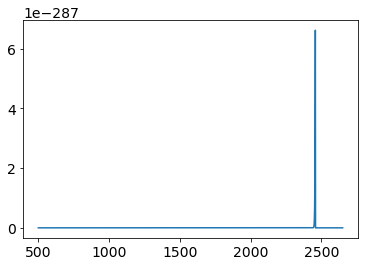

In [29]:
plt.plot(so.inst.xtransmit,so.inst.ytransmit)

In [ ]:
so.inst.base_throughput* so.inst.coupling * so.ao.pywfs_dichroic

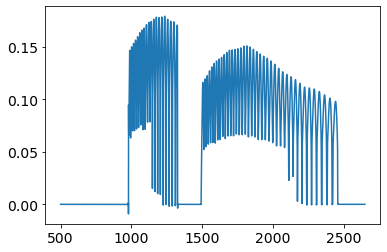

In [40]:
plt.plot(so.inst.xtransmit,so.inst.base_throughput)

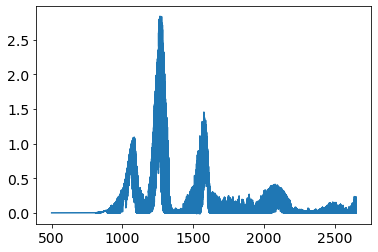

In [32]:
plt.plot(so.plan.v,so.stel.s)

In [34]:
so.plan.model

'phoenix'

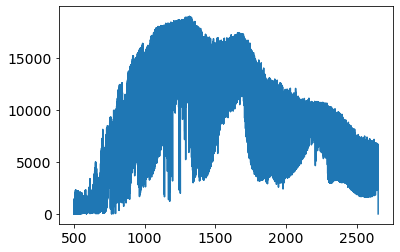

In [36]:
plt.plot(so.plan.v,so.plan.s)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


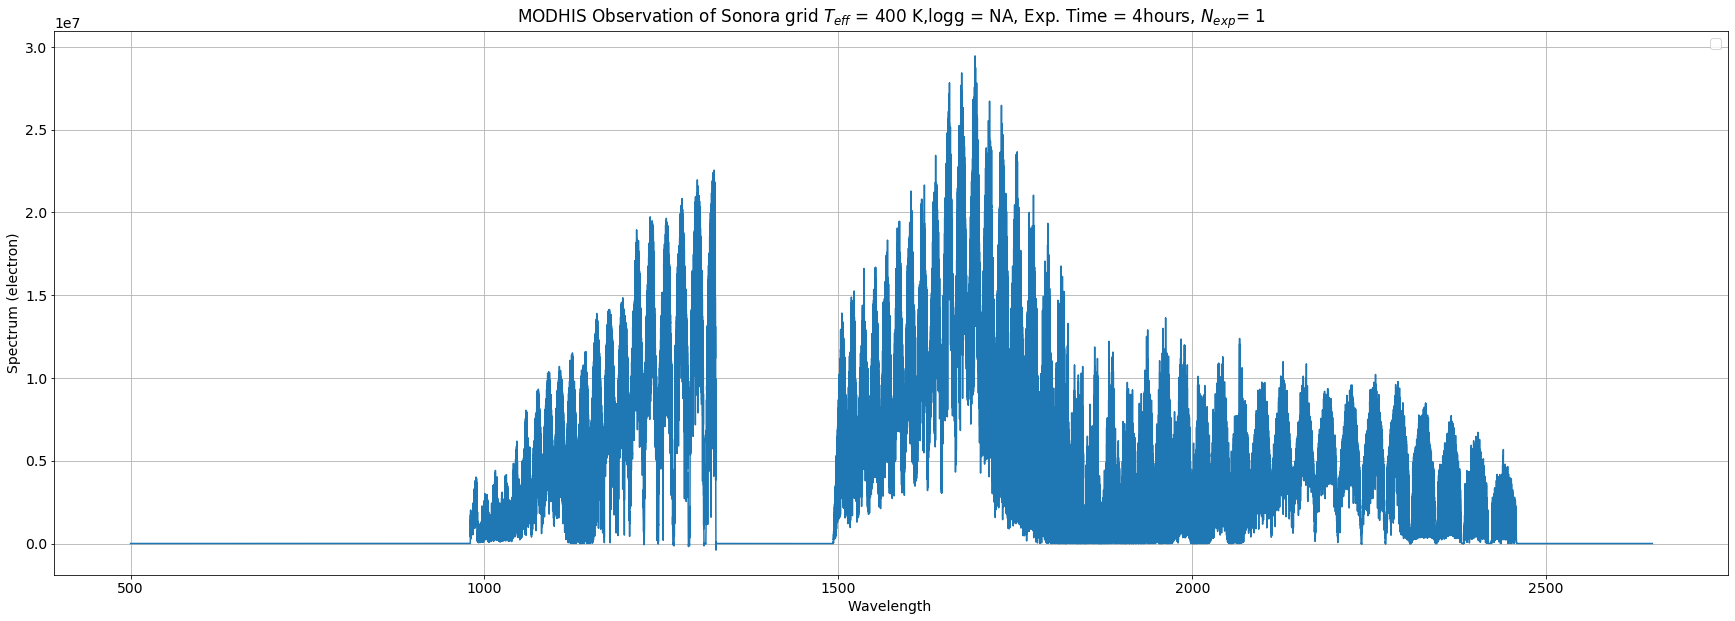

In [15]:
plt.figure(figsize=(30,10))

plt.plot(so.obs.v,so.obs.p)
plt.legend()

plt.xlabel("Wavelength ")
plt.ylabel("Spectrum (electron)")
plt.title(r"MODHIS Observation of Sonora grid $T_{{eff}}$ = 400 K,logg = NA, Exp. Time = 4hours, $N_{{exp}}$= 1")
#plt.ylim(1e-4,1e2)
plt.grid()

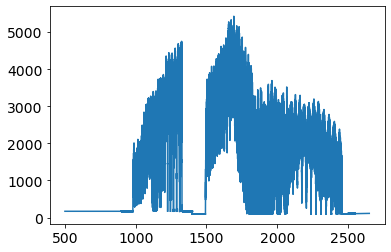

In [16]:
plt.plot(so.obs.v,so.obs.noise_p)

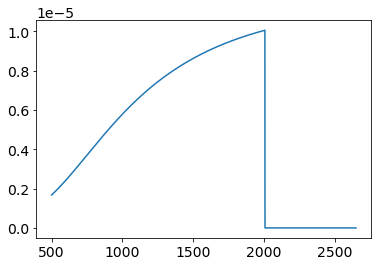

In [17]:
plt.plot(so.obs.v,(so.coron.inst_contr))

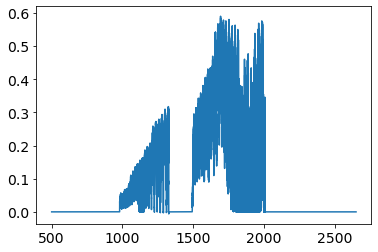

In [18]:
plt.plot(so.obs.v,(so.coron.inst_contr * so.obs.s))

In [19]:
so.obs.p

array([0., 0., 0., ..., 0., 0., 0.])

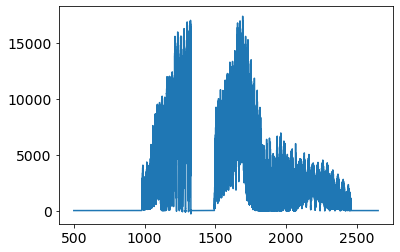

In [20]:
plt.plot(so.obs.v,so.obs.p /so.obs.v)

In [ ]:
plt.plot(so.obs.v,so.coron.inst_contr[0])

In [ ]:
plt.plot(so.inst.xtransmit/1000 * u.um,so.coron.contrast[0])

In [ ]:
so.coron.contrast

In [ ]:
so.ao.ho_wfe_mag

In [ ]:
so.inst.strehl

In [ ]:
so.inst.xtransmit

In [ ]:
p_law_dh = -2.0
telescope_seeing=0.6 *u.arcsec
nactuators = 60. - 2.0
telescope_diameter=30* u.m
fiber_contrast_gain = 10.

In [ ]:
def get_speckle_noise(mode,separations,ao_mag,wvs,filter=None,star_spt=None,telescope=None,ao_mag2=None):
    '''
    Returns the contrast for a given list of separations.

    Inputs: 
    separations  - A list of separations at which to calculate the speckle noise in arcseconds [float list length n]. Assumes these are sorted. 
    ao_mag       - The magnitude in the ao band, here assumed to be I-band
    wvs          - A list of wavelengths in microns [float length m]
    telescope    - A psisim telescope object.

    Outputs: 
    get_speckle_noise - Either an array of length [n,1] if only one wavelength passed, or shape [n,m]

    '''

    #TODO: decide if PIAA will be optional via flag or permanent
    #TODO: add ADC residuals effect
    #TODO: @Max, why feed "filter", "star_spt" if not used. Why feed "telescope" if already available from self.telescope?

    #if self.mode != 'vfn':
    #    print("Warning: only 'vfn' mode has been confirmed")

    if mode == "on-axis":
        return np.ones([np.size(separations),np.size(wvs)])

    if np.size(wvs) < 2:
        wvs = np.array(wvs)

    if mode == "off-axis":
        #-- Deal with nominal MODHIS mode (fiber centered on planet)
        #TODO: this was copied from KPIC instrument. Check if any mods are needed for MODHIS

        #Get the Strehl Ratio
        SR = so.inst.strehl

        p_law_kolmogorov = -11./3
        p_law_ao_coro_filter = p_law_dh#-p_law_kolmogorov 

        r0 = 0.55e-6/(telescope_seeing.to(u.arcsecond).value/206265) * u.m #Easiest to ditch the seeing unit here. 

        #The AO control radius in units of lambda/D
        cutoff = nactuators/2

        contrast = np.zeros([np.size(separations),np.size(wvs)])

        if np.size(separations) < 2:
            separations = np.array([separations.value])*separations.unit

        #Dimitri to put in references to this math
        r0_sc = r0 * (wvs/(0.55*u.micron))**(6./5)
        w_halo = telescope_diameter / r0_sc

        for i,sep in enumerate(separations):
            ang_sep_resel_in = sep/206265/u.arcsecond*telescope_diameter/wvs.to(u.m) #Convert separtiona from arcsec to units of lam/D

            f_halo = np.pi*(1-SR)*0.488/w_halo**2 * (1+11./6*(ang_sep_resel_in/w_halo)**2)**(-11/6.)

            contrast_at_cutoff = np.pi*(1-SR)*0.488/w_halo**2 * (1+11./6*(cutoff/w_halo)**2)**(-11/6.)
            #Fill in the contrast array
            contrast[i,:] = f_halo

            biggest_ang_sep = np.abs(ang_sep_resel_in - cutoff) == np.min(np.abs(ang_sep_resel_in - cutoff))

            contrast[i][ang_sep_resel_in < cutoff] = contrast_at_cutoff[ang_sep_resel_in < cutoff]*(ang_sep_resel_in[ang_sep_resel_in < cutoff]/cutoff)**p_law_ao_coro_filter

        #Apply the fiber contrast gain
        contrast /= fiber_contrast_gain

        #Make sure nothing is greater than 1. 
        contrast[contrast>1] = 1.

        return contrast

    else:
        raise ValueError("'%s' is a not a supported 'mode'" % (mode))

In [ ]:
contrast=get_speckle_noise(mode='off-axis',separations=400 * u.mas,ao_mag=so.ao.ho_wfe_mag,  wvs=so.inst.xtransmit/1000 * u.um)
                  

In [ ]:
plt.plot(so.inst.xtransmit/1000 * u.um,contrast[0])

# Plotting the Spectrum
There are several tools for plotting in plot_tools.py which we loaded earlier as plot_tools. Not all plot functions are currently working well and a lot require certain data paths to be fixed. 

Here is an example how to use some of the key ones that should work! For example, how to plot the SNR spectrum, the base throughput, the background noise, etc. These functions take the so object, so it plots the parameters stored in so from the latest run.

# Running a grid of parameters

# Future Implementation List

- add a function that prints key parameters defined in "so" - perhaps be able to print a summary for each item like telluric, stellar, etc. And also a general one

- make plotting scripts work, cut out ones that dont work or work on saved files not included in the utilities (e.g. only save plot scripts that plot things from so object)

- make things that point to a file path work from the config

- implement variable resolution

- implement testing functions to test things are working properly - one good test is to check the validity of magnitude conversions, like the colors of the given star can be checked

- comment objects.py and add all new variables to init